The purpose of this notebook is to pre-process all our data, which prevents us from having to import it every time we run a new instance of the main notebook. That way, it will be a lot more time-efficient to code in the main notebook.

In [ ]:
%env PYTHONHASHSEED 3
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install -q pyspark

env: PYTHONHASHSEED=3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
from math import sqrt
import pyspark
import os
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName('TwitterData') \
    .config('spark.driver.memory', '16g') \
    .config('spark.executor.memory', '16g') \
    .getOrCreate()
from pyspark.sql.functions import input_file_name
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
!mkdir -p /content/drive/MyDrive/test/

In [ ]:
# The following gets our dataset directly from the download link.
!wget https://snap.stanford.edu/data/twitter.tar.gz
!tar -xvzf twitter.tar.gz

data_path = '/content/twitter/'

In [ ]:
# Wrapping all code necessary to generate all the main RDD containing all data in edge files.
import os
import functools
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, split

spark = SparkSession.builder.getOrCreate()

directory = "/content/drive/My Drive/twitter"

files = [a_file for a_file in os.listdir(directory) if a_file.endswith(".edges")]

# Read each edges file and append them into a list
dfs = []
for file in files:
    ego_user_id = os.path.splitext(file)[0]
    file_path = os.path.join(directory, file)
    df = spark.read.text(file_path)
    df = df.withColumn("ego_user_id", F.lit(ego_user_id))  # Add ego_user_id column
    dfs.append(df)

# Combine all dataframes into a single dataframe
edges_df = functools.reduce(lambda a, b: a.union(b), dfs)

# Generates dataframe of ego users
ego_users = [os.path.splitext(file)[0] for file in files]
ego_users_df = spark.createDataFrame([(ego_user,) for ego_user in ego_users], ["ego_user_id"])

combined_edges_df = edges_df.union(ego_users_df.select("ego_user_id", "ego_user_id"))

edges_df = combined_edges_df.withColumn("follower", combined_edges_df.ego_user_id) \
    .withColumn("followed", explode(split(combined_edges_df.value, " "))) \
    .select("follower", "followed")
edges_rdd = edges_df.rdd

edges_rdd.saveAsTextFile('/content/drive/MyDrive/twitter_analysis/edges_rdd.txt') # Saves the RDD I just generated to a file, so we can read it into our main notebook.

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: ignored

In [ ]:
#featnames_rdd.take(50)

#influential_users = [] # Results from PageRank algorithm, which we will filter our files for - preventing having to process unnecessary files.

def get_feat_files(extension):
  
  # Get a list of all the file paths in the 'twitter' folder for the chosen file extension.
  file_paths = []
  for file_name in os.listdir(data_path):# and file_name in influential_users:
    if extension in file_name:
      file_paths.append(data_path + file_name)
  
  # Read in all the files as text and add the file path as a column.
  dfs = [spark.read.text(file_path).withColumn('file_path', input_file_name()) for file_path in file_paths]
  
  # Concatenates all the dataframes together.
  df = dfs[0]
  for i in range(1, len(dfs)):
    df = df.union(dfs[i])
  raw_rdd = df.rdd

  return raw_rdd

featnames_rdd = get_feat_files("featnames")
featvec_rdd = get_feat_files("egofeat")
#featnames_rdd.saveAsTextFile('/content/drive/MyDrive/twitter_analysis/featnames_rdd.txt') # Saves the RDD I just generated to a file, so we can read it into our main notebook.

In [ ]:
influential_users = ['15924858', '14719129', '53235381', '11928542', '215824411', '90880254', '18996905', '262310943', '100318079', '24542441']

def remove_excess(string):
  problem_chars = ":!.\,/"
  return string.rstrip(problem_chars)

featnames_rdd1 = featnames_rdd.map(lambda x: (x.value, x.file_path)).map(lambda x: (x[0].split()[1], x[1].split('.')[0].split('r/')[1]))
featnames_rdd2 = featnames_rdd1.map(lambda x: (x[1], remove_excess(x[0]))).filter(lambda x: x[0] in influential_users).groupByKey().map(lambda x: (x[0], list(x[1])))

#featvec_rdd = featvec_rdd.map(lambda x: (x.file_path.split('.')[0].split('r/')[1], x.value)).filter(lambda x: x[0] in influential_users).map(lambda x: (x[0], x[1].split(" ")))

#joined_rdd = featnames_rdd.join(featvec_rdd)

In [ ]:
featnames_rdd2.collect()

In [ ]:
def generate_bit_vecs(feat_tuple):
  output = {}
  for i in range(0, len(feat_tuple[1])):
    output[list(feat_tuple[0])[i]] = int(feat_tuple[1][i])
  return output

def remove_features(feat_dict):
  return {key: value for key, value in feat_dict.items() if value != 0}

In [ ]:
print(feature_dictionary)

{'@CaitlinDyess': 0, '#BlackOps2': 1, '#theresnog': 2, '@mateospag': 3, '@caseymckinnon': 4, '@PDelahanty': 5, '#BestInTheWorld': 6, '@hayleybr.com': 7, '@ConfusedLush': 8, '@WWE': 9, '@Paramore_FC_BR': 10, '@_zigga': 11, '@TheGoGame': 12, '@BrodusClay': 13, '@TheCakeWolf': 14, '#TeamBringIt': 15, '@Spotify': 16, '@hayleyporra': 17, '@JustinRYoung': 18, '@TwittaParamore': 19, '@paramonsters': 20, '@matheusthierre': 21, '@romanymalco': 22, '@Shibby2142': 23, '@FuzzyOtterBalls': 24, '#Blops2': 25, '@chzbizman': 26, '@CrashKinkaide': 27, '@lonelysandwich': 28, '@miamiherald': 29, '@MilanMiracle': 30, '@GuildWars2': 31, '@thebellatwins': 32, '@Rubi_': 33, '#SMH': 34, '@DavidVonderhaar': 35, '@TONERAPS': 36, '#VersaEmerge': 37, '@GetGlue': 38, '@invisiblewife': 39, '@ebertchicago': 40, '#GW2beta': 41, '@SublimeWithRome': 42, '@EvilGeniusHD': 43, '@LiveForHayley': 44, '@curley': 45, '@verge)': 46, '@tcpow': 47, '@CalgaryGuru': 48, '@TWiT’s': 49, '#WM28': 50, '@fueledbyramen.com': 51, '@iyaz'

In [ ]:
from pyspark.sql.functions import concat_ws, col
#features_rdd = joined_rdd.map(lambda x: (x[0], generate_bit_vecs(x[1]))).map(lambda x: (x[0], remove_features(x[1]))).map(lambda x: (x[0], list(x[1].keys())))
#feature_dictionary = features_rdd.flatMap(lambda x: x[1]).distinct().zipWithIndex().collectAsMap()
#features_rdd.saveAsTextFile('/content/drive/MyDrive/twitter_analysis/features_rdd.txt')
dictionary_list = [(k, str(v)) for k, v in feature_dictionary.items()]
dictionary_df = spark.createDataFrame(dictionary_list, ['key', 'value'])
dictionary_df = dictionary_df.withColumn('key_value', concat_ws(':', 'key', 'value'))
dictionary_df.select('key_value').write.text('/content/drive/MyDrive/twitter_analysis/features_dictionary.txt')

In [ ]:
featnames_rdd.saveAsTextFile('/content/drive/MyDrive/twitter_analysis/featnames_rdd.txt')

Py4JJavaError: ignored

In [ ]:
from pyspark.ml.linalg import Vectors

def generate_vector(full_feat_dict, input_list):
  output = []
  for item in full_feat_dict.keys():
    if item in input_list:
      output.append(1)
    else:
      output.append(0)
  return Vectors.sparse(len(output), [(i, value) for i, value in enumerate(output)])

sparse_feat_vectors_rdd = featnames_rdd.map(lambda x: (x[0], generate_vector(feature_dictionary, x[1])))

In [ ]:
import math

def generate_similarities(main_rdd):
  output = []
  for i in range(0, len(influential_users)):
    base_rdd = main_rdd.filter(lambda x: x[0] == influential_users[i]).map(lambda x: x[1]).collect()[0]
    base_sv = Vectors.sparse(len(base_rdd), [(i, value) for i, value in enumerate(base_rdd)])
    similarities_rdd = main_rdd.map(lambda x: (x[0], influential_users[i], cosine_similarity(base_sv, x[1])))
    similarities = similarities_rdd.collect()
    output.append(similarities)
  return output

def cosine_similarity(x, y):
  """
  Computes cosine similarity on spark ML SparseVectors x and y
  """
  #multiplication of two 1's is a 1, anything else is a 0, so bitset dot product
  # is equivalent to bitwise and followed by a count of all nonzero elements
  dot_product = x.dot(y)
  #magnitude is sqrt(sum of squares), square of 0 is 0 and square of 1 is 1, 
  #so sum of squares for us is equivalent to count of all nonzero elements
  mag_x = sqrt(x.numNonzeros())
  mag_y = sqrt(y.numNonzeros())
  return dot_product / (mag_x*mag_y)



In [ ]:
cosine_similarities = generate_similarities(sparse_feat_vectors_rdd)

In [ ]:
similar_users = []
for i in range(0, len(cosine_similarities)):
  for item in cosine_similarities[i]:
    if item[2] > 0.4 and item[1] != item[0]:
      similar_users.append(item)
print(similar_users)

orthogonal_users = []
for i in range(0, len(cosine_similarities)):
  for item in cosine_similarities[i]:
    if item[2] < 0.4 and item[1] != item[0]:
      orthogonal_users.append(item)
print(orthogonal_users)

similar_proportion = len(similar_users) / (len(orthogonal_users) + len(similar_users))
orthogonal_proportion = 1- similar_proportion
print(similar_proportion)
print(orthogonal_proportion)

[('90880254', '14719129', 0.43954766145495394), ('53235381', '14719129', 0.5194113811148742), ('14719129', '53235381', 0.5194113811148742), ('90880254', '53235381', 0.6070865630579387), ('14719129', '90880254', 0.43954766145495394), ('53235381', '90880254', 0.6070865630579387), ('100318079', '18996905', 0.5336000974881928), ('18996905', '100318079', 0.5336000974881928)]
[('18996905', '15924858', 0.0), ('14719129', '15924858', 0.0), ('100318079', '15924858', 0.0), ('262310943', '15924858', 0.0), ('11928542', '15924858', 0.0), ('90880254', '15924858', 0.0), ('215824411', '15924858', 0.0), ('24542441', '15924858', 0.0), ('53235381', '15924858', 0.0), ('18996905', '14719129', 0.05947010334500526), ('100318079', '14719129', 0.027066598098038335), ('262310943', '14719129', 0.025976216673306556), ('11928542', '14719129', 0.11322770341445956), ('15924858', '14719129', 0.0), ('215824411', '14719129', 0.0), ('24542441', '14719129', 0.06933752452815364), ('18996905', '53235381', 0.027379283909669

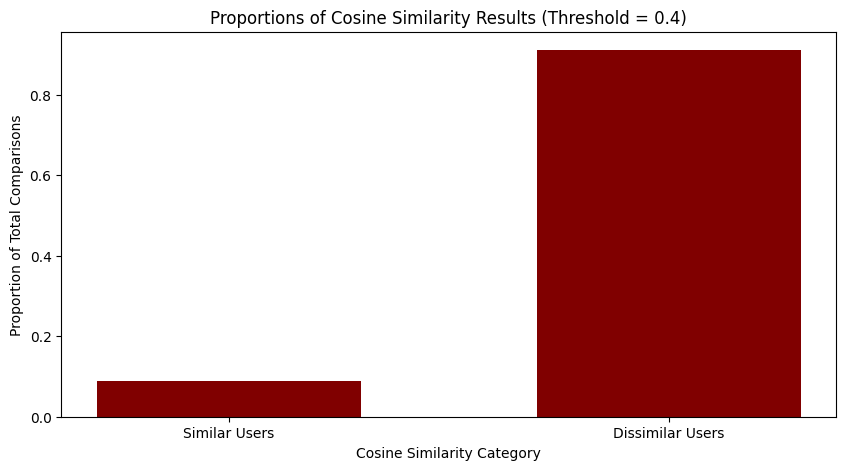

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
x = ["Similar Users", "Dissimilar Users"]
y = [similar_proportion, orthogonal_proportion]
fig = plt.figure(figsize = (10, 5))

plt.bar(x, y, color ='maroon',
        width = 0.6)
 
plt.xlabel("Cosine Similarity Category")
plt.ylabel("Proportion of Total Comparisons")
plt.title("Proportions of Cosine Similarity Results (Threshold = 0.4)")
plt.show()

In [ ]:
similar_users2 = []
for i in range(0, len(cosine_similarities)):
  for item in cosine_similarities[i]:
    if item[2] > 0.1 and item[1] != item[0]:
      similar_users2.append(item)
print(similar_users2)

orthogonal_users2 = []
for i in range(0, len(cosine_similarities)):
  for item in cosine_similarities[i]:
    if item[2] < 0.1 and item[1] != item[0]:
      orthogonal_users2.append(item)
print(orthogonal_users2)

similar_proportion2 = len(similar_users2) / (len(orthogonal_users2) + len(similar_users2))
orthogonal_proportion2 = 1- similar_proportion2
print(similar_proportion2)
print(orthogonal_proportion2)

[('11928542', '14719129', 0.11322770341445956), ('90880254', '14719129', 0.43954766145495394), ('53235381', '14719129', 0.5194113811148742), ('14719129', '53235381', 0.5194113811148742), ('11928542', '53235381', 0.10425720702853737), ('90880254', '53235381', 0.6070865630579387), ('18996905', '11928542', 0.13130643285972254), ('14719129', '11928542', 0.11322770341445956), ('100318079', '11928542', 0.11952286093343936), ('90880254', '11928542', 0.10783277320343841), ('24542441', '11928542', 0.10206207261596574), ('53235381', '11928542', 0.10425720702853737), ('14719129', '90880254', 0.43954766145495394), ('11928542', '90880254', 0.10783277320343841), ('53235381', '90880254', 0.6070865630579387), ('100318079', '18996905', 0.5336000974881928), ('11928542', '18996905', 0.13130643285972254), ('18996905', '100318079', 0.5336000974881928), ('11928542', '100318079', 0.11952286093343936), ('11928542', '24542441', 0.10206207261596574)]
[('18996905', '15924858', 0.0), ('14719129', '15924858', 0.0)

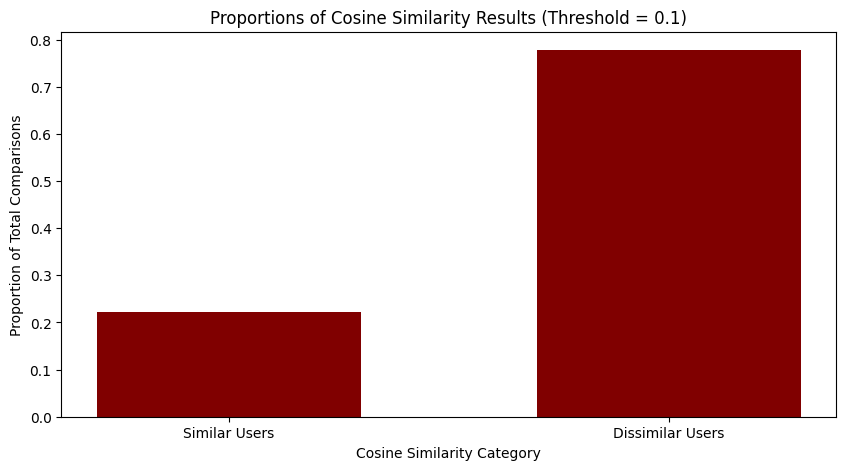

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
x = ["Similar Users", "Dissimilar Users"]
y = [similar_proportion2, orthogonal_proportion2]
fig = plt.figure(figsize = (10, 5))

plt.bar(x, y, color ='maroon',
        width = 0.6)
 
plt.xlabel("Cosine Similarity Category")
plt.ylabel("Proportion of Total Comparisons")
plt.title("Proportions of Cosine Similarity Results (Threshold = 0.1)")
plt.show()